This fil is for CNN application

In [83]:
#pip install opencv-python

In [84]:
 #import libraries 
import sys
import os
# the pah to a repository containing tool_kit 
path_to_tool_kit = os.path.abspath('..')
if path_to_tool_kit not in sys.path:
    sys.path.append(path_to_tool_kit)
import tool_kit as tk
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [85]:
print(path_to_tool_kit)

e:\Cobalt\cobalt


In [86]:
tk.set_path_to_dataset('..')
images = tk.load_data_image()
mask = tk.load_data_mask()
print(' images =\n',images.head())
print(' mask =\n',mask .head())
# mask is a data frame of type pandas that coontains images id and the number of the cells in the image
# images is a data frame of type pandas that contains the images id , the  number of the cells in the imamage , the boolean of the mask and blur

 images =
                             image_id  nb_cells mask  blur
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1  yes     1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1  yes     1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1  yes     1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1  yes     1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1  yes     1
 mask =
                             image_id  nb_cells
0  SIMCEPImages_A01_C1_F1_s01_w1.TIF         1
1  SIMCEPImages_A01_C1_F1_s01_w2.TIF         1
2  SIMCEPImages_A01_C1_F1_s02_w1.TIF         1
3  SIMCEPImages_A01_C1_F1_s02_w2.TIF         1
4  SIMCEPImages_A01_C1_F1_s03_w1.TIF         1


Select the data frame that you want to use 

In [87]:
mask_or_image='image'
if mask_or_image=='mask':
    df=mask
else:
    df=images.copy()
    df.drop(columns=['blur', 'mask'],inplace=True) 
df

,image_id,nb_cells
0,SIMCEPImages_A01_C1_F1_s01_w1.TIF,1
1,SIMCEPImages_A01_C1_F1_s01_w2.TIF,1
2,SIMCEPImages_A01_C1_F1_s02_w1.TIF,1
3,SIMCEPImages_A01_C1_F1_s02_w2.TIF,1
4,SIMCEPImages_A01_C1_F1_s03_w1.TIF,1
...,...,...
19195,SIMCEPImages_P24_C100_F48_s23_w2.TIF,100
19196,SIMCEPImages_P24_C100_F48_s24_w1.TIF,100
19197,SIMCEPImages_P24_C100_F48_s24_w2.TIF,100
19198,SIMCEPImages_P24_C100_F48_s25_w1.TIF,100


## Separation test set et train set

In [88]:
frac=0.2
df_test= df.sample( frac=frac, replace=False, random_state=42)
df_train = df.drop(df_test.index).sample(frac=1, random_state=42)

print('len(df) =',len(df))
print('len(df_train) =',len(df_train))
print('len(df_test) =',len(df_test))
print( 'df_train =\n',df_train.head)
print( 'df_test =\n',df_test.head())    



len(df) = 19200
len(df_train) = 15360
len(df_test) = 3840
df_train =
 <bound method NDFrame.head of                                    image_id  nb_cells
7987    SIMCEPImages_G16_C66_F20_s19_w2.TIF        66
11946   SIMCEPImages_J23_C96_F29_s24_w1.TIF        96
7753    SIMCEPImages_G12_C48_F20_s02_w2.TIF        48
6436    SIMCEPImages_F09_C35_F17_s19_w1.TIF        35
6005     SIMCEPImages_F01_C1_F17_s03_w2.TIF         1
...                                     ...       ...
6501    SIMCEPImages_F11_C44_F17_s01_w2.TIF        44
16791  SIMCEPImages_N24_C100_F42_s21_w2.TIF       100
6738    SIMCEPImages_F15_C61_F17_s20_w1.TIF        61
1067     SIMCEPImages_A22_C91_F1_s09_w2.TIF        91
9125    SIMCEPImages_H15_C61_F23_s13_w2.TIF        61

[15360 rows x 2 columns]>
df_test =
                                   image_id  nb_cells
3234    SIMCEPImages_C17_C70_F7_s18_w1.TIF        70
9459   SIMCEPImages_H22_C91_F23_s05_w2.TIF        91
14698  SIMCEPImages_M06_C23_F39_s25_w1.TIF        23
43

## Test d'affichage d'images et de nombre de cellules dedans  


In [89]:
"""IMG_HEIGHT = 128*2
IMG_WIDTH = 128*2
df_train = tk.data_to_numpy(df=df_train,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)
df_test = tk.data_to_numpy(df=df_test,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)
df_train=df.to_numpy()
df_test=df.to_numpy()"""

'IMG_HEIGHT = 128*2\nIMG_WIDTH = 128*2\ndf_train = tk.data_to_numpy(df=df_train,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)\ndf_test = tk.data_to_numpy(df=df_test,img_width=IMG_HEIGHT,img_height=IMG_WIDTH,mask_or_image=mask_or_image)\ndf_train=df.to_numpy()\ndf_test=df.to_numpy()'

In [90]:
df.shape

(19200, 2)

In [91]:
print( len(df_train))

15360


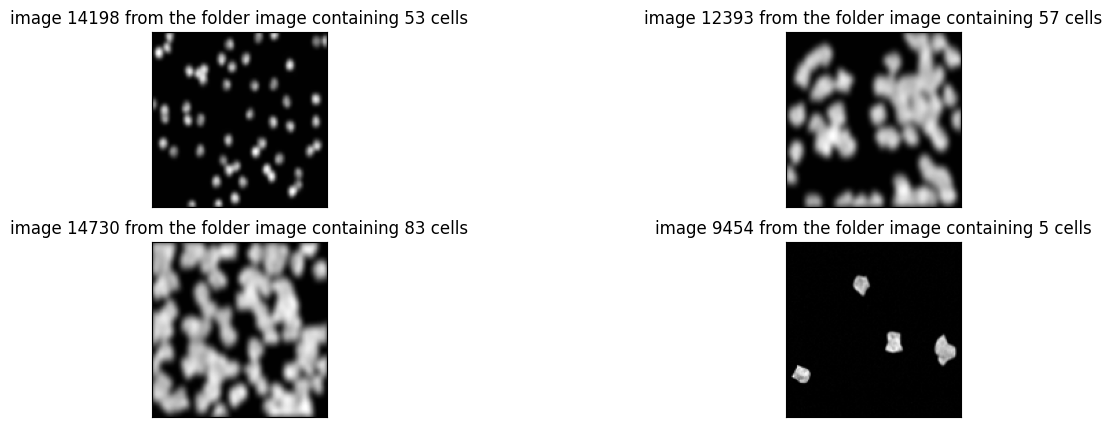

In [92]:

IMG_HEIGHT = 128
IMG_WIDTH = 128
Matrix=df_train
n_img_to_show = 4
fig = plt.figure(figsize=(15,5))
indices=list(range(len(Matrix)))
np.random.shuffle(indices)

for i in range(n_img_to_show):
    ax=fig.add_subplot(2, n_img_to_show//2 , i+1 , xticks=[], yticks=[])
    ax.imshow(np.squeeze(tk.get_image(img_id=Matrix['image_id'].iloc[indices[i]],img_height=IMG_HEIGHT, img_width=IMG_WIDTH, mask_or_image= mask_or_image)),cmap='gray')
    
    ax.set_title(f'image {indices[i]} from the folder {mask_or_image} containing {Matrix['nb_cells'].iloc[indices[i]]} cells')
plt.show()

## convertit les données pour pytorch

In [93]:
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

batch_size = 20 # how many samples per batch to load
valid_size = 0.2 # percentage of training set to use as validation

def create_data_loaders(batch_size, valid_size, train_data, test_data):
  test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
  indices= list( range(len(train_data)))
  np.random.shuffle(indices)
  split= int( np.floor(valid_size * len(train_data)))
  train_indexes, valid_indexes = indices[split:], indices[:split]
  valid_samplers= SubsetRandomSampler(valid_indexes)
  train_samplers= SubsetRandomSampler(train_indexes)
  valid_loader =torch.utils.data.DataLoader( train_data, batch_size = batch_size, sampler = valid_samplers)
  train_loader= torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler= train_samplers)
  return train_loader, valid_loader, test_loader


In [94]:
type(df_train)

pandas.core.frame.DataFrame

In [95]:
from costumize_data import CustomDataset 
transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)) # Resize to desired dimensions
])
train_data= CustomDataset(df_train,transform=transform)
train_data.set_path_to_dataset('..')
test_data= CustomDataset(df_test,transform=transform)
test_data.set_path_to_dataset('..')
train_loader, valid_loader, test_loader =create_data_loaders(batch_size, valid_size, train_data, test_data)

In [96]:
print( train_data.__getitem__(800)[0].shape)

torch.Size([1, 128, 128])


## Image et mask correspondant généré avec u-net

In [97]:
import torch
import torch.nn as nn
import torch.nn.functional as F

dropout = 0.2
nb_filtre = 8

p = 1  # for padding 
k = 3  # for kernel size
s = 1  # for stride
pool_k = 2
pool_s = 2
n_conv= [1 , 1 , 1 , 0]
do_pool= [1 , 1 , 0 ,0]  

class CNN(nn.Module):
    def __init__(self, img_height, img_width):
        super(CNN, self).__init__()

        self.im_height = img_height
        self.im_width = img_width
        
        self.size= 0
        self.conv1 = self.conv_block(in_channels=1, out_channels=nb_filtre*(2**0))
        self.conv2 = self.conv_block(in_channels=nb_filtre*(2**0), out_channels=nb_filtre *(2**1))
        self.conv3 = self.conv_block(in_channels=nb_filtre *(2**1), out_channels=nb_filtre *(2**2))
        self.conv4 = self.conv_block(in_channels=nb_filtre *(2**2), out_channels=nb_filtre *(2**3))

        self.pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s)

        # Calculate output dimensions after all convolutions and pooling
        self.calculate_output_dims()
        print( self.size)
        #print(self.size)
        # First dense layer
        self.dense1 = self.dense_layer(size=self.size)

        # Second dense layer
        self.size //= 4  # Adjust size for the second dense layer
        self.dense2 = self.dense_layer(size=self.size)
        self.size//= 4
        # Final fully connected layer
        self.fc = nn.Linear(self.size, 1)  # Adjusted for output size

    def calculate_output_dims(self):
        # Recalculate height and width after each convolution and pooling layer
        current_filters = nb_filtre
        for i in range(sum(n_conv)):
            # After convolution
            self.im_height = (self.im_height + 2 * p - k) // s + 1
            self.im_width = (self.im_width + 2 * p - k) // s + 1
            self.im_height = (self.im_height + 2 * p - k) // s + 1
            self.im_width = (self.im_width + 2 * p - k) // s + 1
            current_filters = nb_filtre * (2 ** i)
        for i in do_pool:
            if i ==1:
                # After pooling
                self.im_height//= pool_k
                self.im_width //= pool_k
                
                

        # Flattened size for dense layers
        # Note: Using the final number of filters (nb_filtre * (2**n_con))
        self.size = self.im_height * self.im_width * current_filters 
        #note = consider pooling
        


    def dense_layer(self , size ):
        
        block = nn.Sequential(
            nn.Linear(size, size // 2),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(size // 2, size // 4),
            nn.ReLU(inplace=True)
        )
        return block

    def conv_block(self, in_channels, out_channels):
        """
        Convolutional Block: Conv2d -> ReLU -> Dropout -> Conv2d -> ReLU -> Dropout
        """
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=p),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),  # Dropout after each conv layer
            nn.Conv2d(out_channels, out_channels, kernel_size=k, padding=p),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
        return block
    def forward(self, x):
        """
        The forward path is : conv_block --> conv_block --> conv_block --> conv_block --> layer
        """
        if n_conv[0] == 1: 
            x = self.conv1(x)
        if do_pool[0]==1: 
            x=self.pool(x)
        if n_conv[1] == 1: 
            x = self.conv2(x)
        if do_pool[1]==1: 
            x=self.pool(x)
        if n_conv[2] == 1 : 
            x = self.conv3(x)
        if do_pool[3]==1: 
            x=self.pool(x)
        if n_conv[3] == 1: 
            x = self.conv4(x)
        if do_pool[3]==1: 
            x=self.pool(x)
        
        print('At the end of the convolution layer x shape =', x.shape)
        # Flatten before dense layers
        x = x.view(x.size(0), -1)  # Keep batch size intact
        #print( x.shape)
        x = self.dense1(x)
        
        # Uncomment if you have a second dense layer
        x = self.dense2(x)
        #print(f"Dense2 shape: {x.shape}")  # Debug: check shape
        #out put layer 
        x = self.fc(x)
        
        return x


In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F

dropout = 0.2
nb_filtre = 4

p = 1  # for padding 
k = 3  # for kernel size
s = 1  # for stride
pool_k = 2
pool_s = 2
n_conv= [1 , 1, 1 , 1]
do_pool= [1 , 1 , 1 ,1]  

class CNN(nn.Module):
    def __init__(self, img_height, img_width):
        super(CNN, self).__init__()

        self.im_height = img_height
        self.im_width = img_width
        
        self.size= 0
        self.conv1 = self.conv_block(in_channels=1, out_channels=nb_filtre*(2**0))
        self.conv2 = self.conv_block(in_channels=nb_filtre*(2**0), out_channels=nb_filtre *(2**1))
        self.conv3 = self.conv_block(in_channels=nb_filtre *(2**1), out_channels=nb_filtre *(2**2))
        self.conv4 = self.conv_block(in_channels=nb_filtre *(2**2), out_channels=nb_filtre *(2**3))

        self.pool = nn.MaxPool2d(kernel_size=pool_k, stride=pool_s)

        # Calculate output dimensions after all convolutions and pooling
        self.calculate_output_dims()
        #print( 'self size=', self.size)
        #print(self.size)
        # First dense layer
        self.dense1 = self.dense_layer(size=self.size)

        # Second dense layer
        self.size //= 4  # Adjust size for the second dense layer
        self.dense2 = self.dense_layer(size=self.size)
        self.size//= 4
        # Final fully connected layer
        self.fc = nn.Linear(self.size, 1)  # Adjusted for output size

    def calculate_output_dims(self):
        # Recalculate height and width after each convolution and pooling layer
        current_filters = nb_filtre
        for i in range(sum(n_conv)):
            # After convolution
            self.im_height = (self.im_height + 2 * p - k) // s + 1
            self.im_width = (self.im_width + 2 * p - k) // s + 1
            self.im_height = (self.im_height + 2 * p - k) // s + 1
            self.im_width = (self.im_width + 2 * p - k) // s + 1
            current_filters = nb_filtre * (2 ** (i))
        for i in do_pool:
            if i == 1:
         #       print( 'im a in i')
                # After pooling
                self.im_height//= pool_k
                self.im_width //= pool_k
            
                

        # Flattened size for dense layers
        # Note: Using the final number of filters (nb_filtre * (2**n_con))
        self.size = self.im_height * self.im_width * current_filters 
        #note = consider pooling
        


    def dense_layer(self , size ):
        
        block = nn.Sequential(
            nn.Linear(size, size // 2),
            #nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(size // 2, size // 4),
            #nn.ReLU(inplace=True)
        )
        return block

    def conv_block(self, in_channels, out_channels):
        """
        Convolutional Block: Conv2d -> ReLU -> Dropout -> Conv2d -> ReLU -> Dropout
        """
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=k, padding=p),
            #nn.ReLU(inplace=True),
            #nn.Dropout(dropout),  # Dropout after each conv layer
            
        )
        return block
    def forward(self, x):
        """
        The forward path is : conv_block --> conv_block --> conv_block --> conv_block --> layer
        """
        if n_conv[0] == 1: 
            x = self.conv1(x)
        if do_pool[0]==1: 
            x=self.pool(x)
        if n_conv[1] == 1: 
            x = self.conv2(x)
        if do_pool[1]==1: 
            x=self.pool(x)
        if n_conv[2] == 1 : 
            x = self.conv3(x)
        if do_pool[2]==1: 
            x=self.pool(x)
        if n_conv[3] == 1: 
            x = self.conv4(x)
        if do_pool[3]==1: 
            x=self.pool(x)
        
        #print( 'size=', self.size )
        
        #print('At the end of the convolution layer x shape =', x.shape)
        # Flatten before dense layers
        x = x.view(x.size(0), -1)  # Keep batch size intac
        #print ('x=', x.shape)
        #print( x.shape)
        x = self.dense1(x)
        
        # Uncomment if you have a second dense layer
        x = self.dense2(x)
        #print(f"Dense2 shape: {x.shape}")  # Debug: check shape
        #out put layer 
        x = self.fc(x)
        
        return x


In [99]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device '+str(device))

Using device cpu


In [100]:
CNN_1 = CNN( img_height=IMG_HEIGHT, img_width=IMG_WIDTH )
CNN_1.to(device=device)  

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv4): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=1024, out_features=512, bias=True)
  )
  (dense2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [101]:
#CNN(train_data.__getitem__(0)[0])
train_data.__getitem__(0)[0].shape

torch.Size([1, 128, 128])

In [102]:
single_batch = torch.randn(1, 1, IMG_HEIGHT, IMG_WIDTH)
output = CNN_1(single_batch)
print( output)

tensor([[0.0811]], grad_fn=<AddmmBackward0>)


In [103]:
from torchsummary import summary
summary(CNN_1, input_size=(1, IMG_HEIGHT, IMG_WIDTH))  # Explicitly set batch_size=1 # channels, height, width )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 128, 128]              40
         MaxPool2d-2            [-1, 4, 64, 64]               0
            Conv2d-3            [-1, 8, 64, 64]             296
         MaxPool2d-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,168
         MaxPool2d-6           [-1, 16, 16, 16]               0
            Conv2d-7           [-1, 32, 16, 16]           4,640
         MaxPool2d-8             [-1, 32, 8, 8]               0
            Linear-9                 [-1, 1024]       2,098,176
          Dropout-10                 [-1, 1024]               0
           Linear-11                  [-1, 512]         524,800
           Linear-12                  [-1, 256]         131,328
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [104]:
criterion =nn.MSELoss()
#criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(CNN_1.parameters(), lr=0.01)

In [105]:
n_epochs = 20 # number of epochs to train the model

def training(n_epochs, train_loader, valid_loader, model, criterion, optimizer):

  train_losses, valid_losses = [], []
  # initialize tracker for minimum validation loss
  valid_loss_min = np.inf  # set initial "min" to infinity

  for epoch in range(n_epochs):
      
      train_loss, valid_loss = 0, 0 # monitor losses

      # train the model
      model.train() # prep model for training
      for data, label in train_loader:
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          optimizer.zero_grad()
          output=model(data)
          
          loss=criterion(output,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * data.size(0) # update running training loss
      
      # validate the model
      model.eval()
      for data, label in valid_loader:
          
          
          data = data.to(device=device, dtype=torch.float32)
          label = label.to(device=device, dtype=torch.float32)
          with torch.no_grad():
              output=model( data)
          loss=criterion(output,label)
          valid_loss += loss.item() * data.size(0)
    
      # calculate average loss over an epoch
      train_loss /= len(train_loader.sampler)
      valid_loss /= len(valid_loader.sampler)
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)

      print('epoch: {} \ttraining Loss: {:.6f} \tvalidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))

      # save model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
          valid_loss_min,
          valid_loss))
          torch.save(model.state_dict(), 'model.pt')
          valid_loss_min = valid_loss

  return train_losses, valid_losses

In [ ]:
train_losses, valid_losses=training(n_epochs, train_loader, valid_loader, CNN_1, criterion, optimizer)

c:\Users\LENOVO\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\LENOVO\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\LENOVO\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.ms

epoch: 1 	training Loss: 206925.225207 	validation Loss: 913.604619
validation loss decreased (inf --> 913.604619).  Saving model ...
epoch: 2 	training Loss: 971.383400 	validation Loss: 909.433639
validation loss decreased (913.604619 --> 909.433639).  Saving model ...
epoch: 3 	training Loss: 965.794512 	validation Loss: 943.478357
epoch: 4 	training Loss: 968.535866 	validation Loss: 896.056505
validation loss decreased (909.433639 --> 896.056505).  Saving model ...
epoch: 5 	training Loss: 927.971638 	validation Loss: 1038.170121
epoch: 6 	training Loss: 923.961621 	validation Loss: 905.407486
epoch: 7 	training Loss: 926.585398 	validation Loss: 883.323598
validation loss decreased (896.056505 --> 883.323598).  Saving model ...
epoch: 8 	training Loss: 927.034860 	validation Loss: 891.481466


Text(0, 0.5, 'loss value')

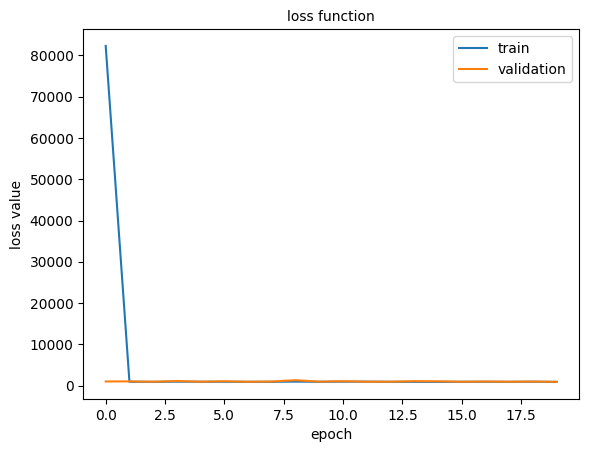

In [79]:
plt.plot(range(n_epochs), train_losses)
plt.plot(range(n_epochs), valid_losses)
plt.legend(['train', 'validation'], prop={'size': 10})
plt.title('loss function', size=10)
plt.xlabel('epoch', size=10)
plt.ylabel('loss value', size=10)

In [80]:
def evaluation(model, test_loader, criterion):

  # initialize lists to monitor test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(101))
  class_total = list(0. for i in range(101))
  #creat a empty dict of 101 elements
  dict={}
  for i in range(1,101):
      dict[i]=[]
  model.eval() # prep model for evaluation
  for data, label in test_loader:
      data = data.to(device=device, dtype=torch.float32)
      label = label.to(device=device, dtype=torch.long)
      with torch.no_grad():
          output = model(data) # forward pass: compute predicted outputs by passing inputs to the model
      loss = criterion(output, label)

      test_loss += loss.item()*data.size(0)
      
      pred = torch.floor(output) # convert output probabilities to predicted class
      correct = np.squeeze(pred.eq(label.data.view_as(pred))) # compare predictions to true label
      # calculate test accuracy for each object class
      for i in range(len(label)):
          number_expected = label.data[i]
          class_correct[number_expected] += correct[i].item()
          class_total[number_expected] += 1
          number_expected = int(number_expected)
          dict[number_expected].append(int(pred[i]))
      
  
  #print and return the results
  for i in range(100):
     if class_total[i] > 0 : 
        print( 'For the true value ', i, 'the predicted values are ', dict[i])
  # calculate and print avg test loss
  test_loss = test_loss/len(test_loader.sampler)
  print('test Loss: {:.6f}\n'.format(test_loss))
  for i in range(100):
      if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print('Test accuracy of %1s: %2.2f%% (%2d/%2d)' % (str(i), accuracy, np.sum(class_correct[i]), np.sum(class_total[i])))
      #else: 
        #print('Test accuracy of %1s: N/A (0/0)' % str(i))

  print('\ntest accuracy (overall): %2.2f%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))

In [81]:
evaluation( CNN_1, test_loader, criterion)

For the true value  1 the predicted values are  [38, 37, 37, 37, 38, 38]
For the true value  5 the predicted values are  [39, 38, 38, 40, 38, 39, 38, 40, 39, 40, 39, 39]
For the true value  10 the predicted values are  [41, 41, 40, 42, 43, 40, 40, 39, 41]
For the true value  14 the predicted values are  [41, 41, 43, 40, 40, 42, 39, 41, 42, 43, 41, 41]
For the true value  18 the predicted values are  [42, 43, 42, 43, 42, 45, 44, 42, 42, 46, 44]
For the true value  23 the predicted values are  [47, 42, 45, 44, 42, 42, 43, 43, 42, 47, 49, 43]
For the true value  27 the predicted values are  [48, 44, 45, 43, 43, 46, 46, 43, 45, 45, 43, 48, 47]
For the true value  31 the predicted values are  [45, 43, 46, 46, 49, 46, 48, 52, 50, 49, 45, 44]
For the true value  35 the predicted values are  [49, 48, 50, 48, 47, 49, 47, 52, 51, 51, 49]
For the true value  40 the predicted values are  [47, 50, 46, 51, 51, 50, 47]
For the true value  44 the predicted values are  [53, 55, 47, 53, 48, 51, 49, 49, 